In [3]:
import itertools
import os
from collections import namedtuple
from math import exp

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.helpers import (AllAsymptotics,
load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe,
AllDeltas)
from empirical_privacy import laplace_mechanism, config

from notebook_context import *
%matplotlib inline

In [34]:
epsilons = [
#     0.01,
    0.1,
#      1.,
]
dses = [{
        'database_0' : (0, 0, 0),
        'database_1' : (1, 0, 0),
        'sensitivity': 1.,
        'epsilon'    : eps,
        'delta'      : 0.
} for eps in epsilons]

asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack'
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 3,
    'n_trials_per_training_set_size': 300,
    'n_max'              : 2**8,
    'validation_set_size': 2**10,
    'p'                  : 0.99,  # for bootstrap
    'n_bootstraps'       : 1000,  # for bootstrap
    'in_memory'          : True
}

d = 3

In [40]:
CCCs = dict()
Alls = dict()
AAs = dict()
CLBDs = dict()


for (i, ds) in enumerate(dses):
    eps = epsilons[i]
    CLAIMED_EPS = eps
    All = AllDeltas(
            gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
            dataset_settings=ds,
            asymptotic_settings=asys,
            claimed_epsilon=CLAIMED_EPS
    )
    Alls[eps] = All
    CLBDs[eps] = All.requires()
    AAs[eps] = [CLBD.requires()['asymptotic_accuracy'] for CLBD in CLBDs[eps]]
    CCCs[eps] = [AA.requires()['CCC'] for AA in AAs[eps]]
    

In [41]:
#uncomment this to recompute the top level tasks

for AA in AAs[eps]:
    AA.delete_outputs()
for clbd in CLBDs[eps]:
    clbd.delete_outputs()

In [42]:
luigi.build([All for All in Alls.values()], workers=4, log_level='ERROR', local_scheduler=True)  # do bootstrap using 2 workers since each bootstrap is parallelized

True

### Plot outcomes for all trials

In [43]:
eps = 0.1
CLAIMED_EPS = eps

AAs = Alls[eps].requires()
DF = load_completed_AAs_into_dataframe(AAs)

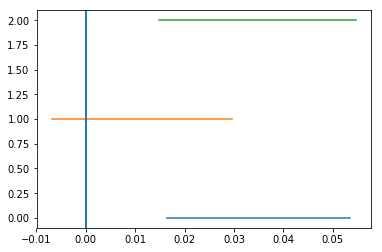

In [44]:
plt.figure()
for (i,CLBD) in enumerate(AAs):
    with CLBD.output().open() as f:
        deltas = dill.load(f)
        plt.plot([deltas['lower_bound'], deltas['upper_bound']], [i, i])
    plt.axvline(0)

In [ ]:
configure_plotting_for_publication()

SAVE_FIGURES_FOR_LATEX = False


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p_two_sided, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

In [ ]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)
print(DFccc.shape)

confidence_interval_width = 0.01
confidence_interval_prob = 0.9
    
def plot_CCC_DF(DF, doc_ind=None, d=3):
    global SAVE_FIGURES_FOR_LATEX
    print('Training set sizes = ',
          DF.training_set_size.min(),
          '--',
          DF.training_set_size.max()
         )
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
#     DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    DF.drop(index=DF[DF.classifier_accuracy < 0.5].index, inplace=True)
    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue='doc_ind',
        legend=None,
        palette=cp,
    
    )
   
    # curve for all the data
    d=3
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    m, C = asymptotic_curve(ks, y)
    print(f'm={m} C={C}')
    
    # bootstrap for ub
    boot_res = compute_bootstrapped_upper_bound(x, d, fit_model, y,
                                 confidence_interval_prob,
                                 confidence_interval_width)
    samples = boot_res['bootstrap_samples'] 
    
    ub = boot_res['ub']
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base),
                     np.log(np.max(x))/np.log(base),
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    labeled_axhline(ub, 'U.B.', 'k', handle)
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--')
#     labeled_axhline(pc(eps, delta), '$C_\infty^*$', 'r', handle)
    
    plt.xticks(x, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in x],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.75},
                 rug=False,
                 vertical=True,
                 color='g',
                ax=ax2)

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_4_bootstrap_visualization.png'))


    
# call the function
plot_CCC_DF(DFccc, 1)


In [ ]:
from functools import partial

from experiment_framework.asymptotic_analysis import bootstrap_ci, asymptotic_privacy_lr
from experiment_framework.differential_privacy import compute_delta
from experiment_framework.calculations import accuracy_to_statistical_distance

def get_bootstrap_model(DF, doc_ind, d= 3):
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    n_docs = DF.doc_ind.nunique()
    
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    return {'training_set_sizes':x, 'y':y, 'fit_model':fit_model, 'ks':ks}

DFccc[DFccc.classifier_accuracy < 0.5] = 0.5
model = get_bootstrap_model(DFccc, 0)
accuracy_results = np.array([])


# results = more_results(model, 10)
# a

In [ ]:
results = bootstrap_ci(
    10000,
    X=model['training_set_sizes'],
    y=model['y'],
    f=partial(asymptotic_privacy_lr, fit_model=model['fit_model'], d=d),
    random_state_offset=accuracy_results.size
)
accuracy_results = np.concatenate((accuracy_results, results))
deltas = np.array([compute_delta(stat_dist=accuracy_to_statistical_distance(accu), epsilon=CLAIMED_EPS)
                   for accu in accuracy_results])
_ = plt.hist(deltas)
alpha = (1-0.999)/2 * 100.0
lb = np.percentile(deltas, alpha)
ub = np.percentile(deltas, 100-alpha)
plt.axvline(lb, color='r')
plt.axvline(ub, color='r')
plt.axvline(0, color='k')
plt.axvline(np.mean(deltas), color='g')

In [ ]:
bootstrap_xs = np.logspace(1, np.log2(deltas.size), base=2).astype(np.int)

In [ ]:
plt.plot(bootstrap_xs, [np.std(deltas[0:i]) for i in bootstrap_xs], '-*r')
plt.title('std as a function of bootstrap samples')

In [ ]:
def bootstrap_t(samples):
    